In [1]:
import os
import pyproj
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as sg
import cartopy.crs as ccrs

In [2]:
data_dir = os.path.join(os.getcwd(), 'data')
print(data_dir)

/home/jack/Repos/beni-confiscati/data


## Data

Source: Regione Toscana – [Beni confiscati alla criminalità organizzata](http://dati.toscana.it/dataset/rt-beniconfiscati)

The dataset is released under the [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license.

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'beniconfiscatiXall.csv'), sep='|')

## Overview

In [4]:
df.shape

(497, 24)

In [5]:
df.columns

Index(['id', 'nome', 'gbnord', 'gbest', 'tipologia',
       'descrizione_categoria_bene', 'macroiteramm',
       'descrizione_sottocategoria_bene', 'prov', 'comune', 'indirizzo',
       'link_scheda_rt', 'desitergiu', 'destipodest', 'descrizioneentedest',
       'colonna', 'dataprovvdest', 'annoprovvdest', 'ufficio_giudiziario',
       'distretto', 'procedura', 'numero_decreto', 'fonte', 'Unnamed: 23'],
      dtype='object')

In [6]:
df.head()

,id,nome,gbnord,gbest,tipologia,descrizione_categoria_bene,macroiteramm,descrizione_sottocategoria_bene,prov,comune,...,descrizioneentedest,colonna,dataprovvdest,annoprovvdest,ufficio_giudiziario,distretto,procedura,numero_decreto,fonte,Unnamed: 23
0,A-PT-59394-S,Agliana - A-PT-59394-S - aziende - Commercio i...,4863122.5,1660922.21,Aziende in gestione,"Commercio ingrosso-dettaglio, riparazione veic...",In gestione,"Commercio ingrosso-dettaglio, riparazione veic...",Pistoia,Agliana,...,NaN,NaN,NaN,NaN,Tribunale,Prato,Misure di Prevenzione,NaN,ANBSC-OR-2018-01-03,NaN
1,I-LU-15621,Altopascio - I-LU-15621 - immobili - Appartame...,4852349.0,1637914.00,Immobili destinati,Unità immobiliare per uso di abitazione e assi...,Destinato,Appartamento in condominio,Lucca,Altopascio,...,Comuni,NaN,2003.0,29/05/2003,Tribunale,REGGIO DI CALABRIA,7/1998,107.0,ANBSC-OR-2018-01-03,NaN
2,I-LU-15632,Altopascio - I-LU-15632 - immobili - Appartame...,4852349.0,1637914.00,Immobili destinati,Unità immobiliare per uso di abitazione e assi...,Destinato,Appartamento in condominio,Lucca,Altopascio,...,Comuni,NaN,2003.0,29/05/2003,Tribunale,REGGIO DI CALABRIA,7/1998,107.0,ANBSC-OR-2018-01-03,NaN
3,I-LU-15640,Altopascio - I-LU-15640 - immobili - Appartame...,4852349.0,1637914.00,Immobili destinati,Unità immobiliare per uso di abitazione e assi...,Destinato,Appartamento in condominio,Lucca,Altopascio,...,Comuni,NaN,2003.0,29/05/2003,Tribunale,REGGIO DI CALABRIA,7/1998,107.0,ANBSC-OR-2018-01-03,NaN
4,I-LU-15648,Altopascio - I-LU-15648 - immobili - Appartame...,4852349.0,1637914.00,Immobili destinati,Unità immobiliare per uso di abitazione e assi...,Destinato,Appartamento in condominio,Lucca,Altopascio,...,Comuni,NaN,2003.0,29/05/2003,Tribunale,REGGIO DI CALABRIA,7/1998,107.0,ANBSC-OR-2018-01-03,NaN


In [7]:
df.iloc[0]

id                                                                      A-PT-59394-S
nome                               Agliana - A-PT-59394-S - aziende - Commercio i...
gbnord                                                                   4.86312e+06
gbest                                                                    1.66092e+06
tipologia                                                        Aziende in gestione
descrizione_categoria_bene         Commercio ingrosso-dettaglio, riparazione veic...
macroiteramm                                                             In gestione
descrizione_sottocategoria_bene    Commercio ingrosso-dettaglio, riparazione veic...
prov                                                                         Pistoia
comune                                                                       Agliana
indirizzo                                                      Indirizzo imprecisato
link_scheda_rt                                                   

## Column id

In [8]:
len(df.id.unique())

497

In [9]:
print(df.id.iloc[0])

A-PT-59394-S


## Column nome

In [10]:
len(df.nome.unique())

497

It looks like that `nome` contains the same information available in `id`, `tipologia` and `descrizione_categoria_bene`.

In [11]:
print(df.nome.iloc[0])

Agliana - A-PT-59394-S - aziende - Commercio ingrosso-dettaglio, riparazione veicoli, beni personali, casa - Indirizzo imprecisato


## Columns `gbnord` and `gbest`

There is no documentation for this dataset. However, I am pretty sure that here `gb` stands for [Gauss-Boaga](https://en.wikipedia.org/wiki/Gauss%E2%80%93Boaga_projection), a map projection commonly used in Italy. This means that this dataset is georeferentiated and we can plot each record on a map.

We will come back to the columns `gbnord` and `gbest` when we create a geopandas `GeoDataFrame`.

## Column `tipologia`

In [12]:
df.tipologia.unique()

array(['Aziende in gestione', 'Immobili destinati',
       'Immobili in gestione', 'Aziende destinate'], dtype=object)

We can group the data, count the occurrences and print the resulting pandas `Series`.

In [13]:
df.groupby('tipologia')['nome'].count().sort_values(ascending=False)

tipologia
Immobili in gestione    381
Immobili destinati       69
Aziende in gestione      45
Aziende destinate         2
Name: nome, dtype: int64

Or display a barchart. It's better to display horizontal bars and sort them.

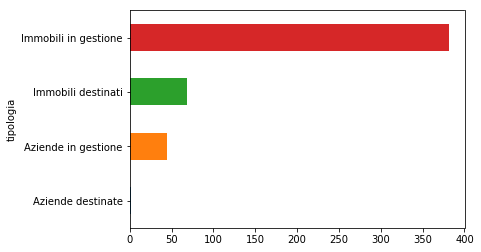

In [16]:
df.groupby('tipologia')['nome'].count().sort_values(ascending=True).plot.barh()

Most of these confiscations involve some real estate properties (*beni immobili*), not companies (*aziende*).

In [17]:
df['is_a_company'] = df.tipologia.isin(['Aziende in gestione', 'Aziende destinate'])

In [18]:
df.groupby('is_a_company')['nome'].count()

is_a_company
False    450
True      47
Name: nome, dtype: int64

## Column `descrizione_categoria_bene`

In [19]:
df.descrizione_categoria_bene.unique()

array(['Commercio ingrosso-dettaglio, riparazione veicoli, beni personali, casa',
       'Unità immobiliare per uso di abitazione e assimilabile',
       'Terreno', 'Alberghi e ristoranti',
       'Box, garage, autorimessa, posto auto',
       'Appartamento in condominio', nan, 'Abitazione indipendente',
       'Magazzino, Locale di deposito',
       'Unità uso abit. e assimil. - non definito', 'Altro',
       'Altra unità immobil. - non definito',
       'Agricoltura, caccia e silvicoltura', 'Fabbricato industriale',
       'Terreno agricolo', 'Terreno - non definito',
       'Trasporti, magazzinaggio e comunicazioni',
       'Attività immobiliari, noleggio, informatica, ricerca, servizi alle imprese',
       'Costruzioni', 'Settore imprecisato', 'Negozio, Bottega',
       'Unità immobiliare a destinazione commerciale e industriale',
       'Attività finanziarie',
       'Altri servizi pubblici, sociali e personali', 'Villa',
       'Terreno con fabbricato rurale', 'Altra unità immobi

If we use `[[]]` instead of `[]` we obtain a pandas `DataFrame` instead of a oandas `Series`.

In [20]:
categoria_bene = df.groupby('descrizione_categoria_bene')[['nome']]\
    .count()\
    .rename(columns={'nome': 'count'})

categoria_bene.sort_values(by='count', ascending=False)

,count
descrizione_categoria_bene,
Terreno agricolo,147
Appartamento in condominio,73
"Box, garage, autorimessa, posto auto",64
Unità immobiliare per uso di abitazione e assimilabile,50
Unità uso abit. e assimil. - non definito,16
Fabbricato industriale,15
Terreno,14
Terreno - non definito,11
"Attività immobiliari, noleggio, informatica, ricerca, servizi alle imprese",11


We can display a barplot. We have too many categories here, so we don't use different colors: they would be too many and the plot would look too messy.

It seems that at the moment in pandas we cannot change the plot size by using the syntax `df.plot().barh()`. We have to use the syntax `df.plot(kind='barh')` instead.

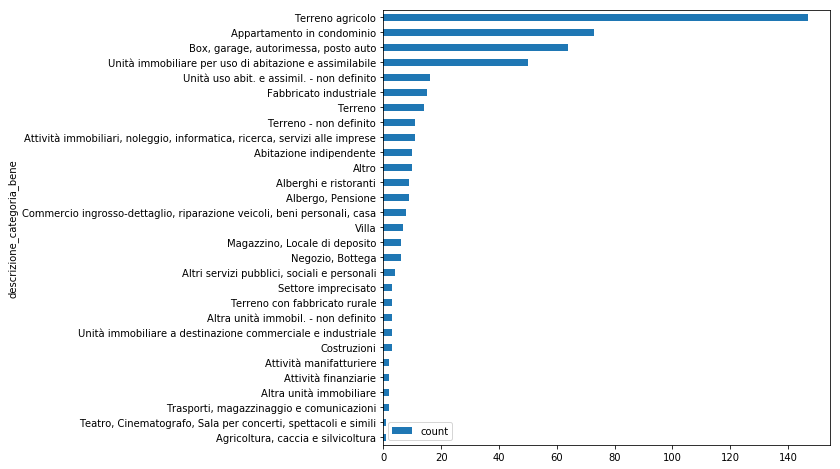

In [21]:
categoria_bene.sort_values(by='count').plot(figsize=(8, 8), kind='barh')

## Column `macroiteramm`

In [22]:
df.macroiteramm.unique()

array(['In gestione', 'Destinato'], dtype=object)

In [23]:
df.groupby('macroiteramm')['nome'].count()

macroiteramm
Destinato       71
In gestione    426
Name: nome, dtype: int64

This column seems to contain some of the information already available in the column `tipologia`.

In [24]:
print(df.tipologia.iloc[0])
print(df.macroiteramm.iloc[0])
print(df.tipologia.iloc[1])
print(df.macroiteramm.iloc[1])

Aziende in gestione
In gestione
Immobili destinati
Destinato


In [25]:
df['is_managed'] = df.macroiteramm == 'In gestione'
df.groupby('is_managed')['nome'].count()

is_managed
False     71
True     426
Name: nome, dtype: int64

## Column `descrizione_sottocategoria_bene`

In [26]:
df.descrizione_sottocategoria_bene.unique()

array(['Commercio ingrosso-dettaglio, riparazione veicoli, beni personali, casa',
       'Appartamento in condominio',
       'Box, garage, autorimessa, posto auto', 'Alberghi e ristoranti',
       'Società a responsabilità limitata', 'Abitazione indipendente',
       'Magazzino, Locale di deposito',
       'Unità uso abit. e assimil. - non definito', 'Altro',
       'Altra unità immobil. - non definito',
       'Agricoltura, caccia e silvicoltura', 'Fabbricato industriale',
       'Terreno agricolo', 'Terreno - non definito',
       'Trasporti, magazzinaggio e comunicazioni',
       'Attività immobiliari, noleggio, informatica, ricerca, servizi alle imprese',
       'Costruzioni', 'Settore imprecisato', 'Negozio, Bottega',
       'Palazzo di pregio artistico e storico, Castello',
       'Attività finanziarie',
       'Altri servizi pubblici, sociali e personali', 'Villa',
       'Terreno con fabbricato rurale', 'Albergo, Pensione',
       'Teatro, Cinematografo, Sala per concerti, spe

## Column `prov`

In [27]:
df.prov.unique()

array(['Pistoia', 'Lucca', 'Arezzo', 'Massa-Carrara', 'Firenze',
       'Livorno', 'Pisa', 'Siena', 'Grosseto', 'Prato'], dtype=object)

The majority of these confiscations occurr in the Province of Lucca, followed by Arezzo and Pisa.

In [28]:
df.groupby('prov')['nome'].count().sort_values(ascending=False)

prov
Lucca            160
Arezzo            70
Pisa              57
Livorno           49
Pistoia           40
Firenze           34
Prato             31
Siena             24
Massa-Carrara     21
Grosseto          11
Name: nome, dtype: int64

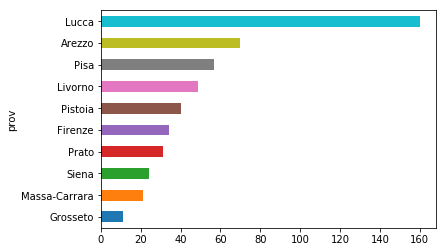

In [29]:
df.groupby('prov')['nome'].count().sort_values().plot.barh()

## Column `comune`

In [30]:
df.comune.unique()

array(['Agliana', 'Altopascio', 'Anghiari', 'Arezzo', 'Aulla',
       'Bagno a Ripoli', 'Buggiano', 'Camaiore', 'Campi Bisenzio',
       'Campiglia Marittima', 'Camporgiano', 'Carrara', 'Cascina',
       'Castagneto Carducci', 'Castelfranco di Sotto', 'Cecina',
       'Chianciano Terme', 'Empoli', 'Firenze', 'Lucca',
       'Forte dei Marmi', 'Fucecchio', 'Larciano',
       'Marciano della Chiana', 'Licciana Nardi', 'Livorno', 'Vecchiano',
       'Massa', 'Massa e Cozzile', 'Monsummano Terme', 'Montale',
       'Monte Argentario', 'Montecatini-Terme', 'Montecatini Terme',
       'Montemurlo', 'Montepulciano', "Monteroni d'Arbia", 'Montevarchi',
       'Montignoso', "Montopoli in Val d'Arno", 'Murlo', 'Pietrasanta',
       'Piombino', 'Pisa', 'Poggio a Caiano', 'Pontremoli',
       'Portoferraio', 'Prato', 'Quarrata', 'Radda in Chianti',
       'Radicofani', 'Rosignano Marittimo', 'San Vincenzo',
       'Santa Maria a Monte', 'Sesto Fiorentino', 'Sorano',
       'Tavarnelle Val di Pesa'

We can group by `prov` and `comune` to obtain a pandas `Series` whose index is a `MultiIndex`.

In [31]:
ranking = df.groupby(['prov', 'comune'])['nome'].count()
print(type(ranking.index))
ranking

<class 'pandas.core.indexes.multi.MultiIndex'>


prov           comune                 
Arezzo         Anghiari                     1
               Arezzo                      21
               Marciano della Chiana       43
               Montevarchi                  1
               Terranuova Bracciolini       4
Firenze        Bagno a Ripoli               2
               Campi Bisenzio               5
               Empoli                       4
               Firenze                     12
               Fucecchio                    1
               Sesto Fiorentino             2
               Tavarnelle Val di Pesa       8
Grosseto       Monte Argentario             8
               Sorano                       3
Livorno        Campiglia Marittima          5
               Castagneto Carducci         14
               Cecina                      12
               Livorno                      3
               Piombino                     4
               Portoferraio                 2
               Rosignano Marittimo       

Here are the 3 municipalities with the highest number of confiscations.

In [32]:
ranking.sort_values(ascending=False)[:3]

prov    comune               
Lucca   Camporgiano              123
Arezzo  Marciano della Chiana     43
Pisa    Castelfranco di Sotto     24
Name: nome, dtype: int64

Apparently, almost 77% of the confiscations in the Province of Lucca take place in the town of Camporgiano.

In [33]:
ratio_in_lucca = len(df[df.comune == "Camporgiano"]) / len(df[df.prov == "Lucca"])
ratio_in_tuscany = len(df[df.comune == "Camporgiano"]) / df.shape[0]
print('Confiscations in Camporgiano:\n{:.1%} (as % in Lucca)\n{:.2%} (as % in Tuscany)'
      .format(ratio_in_lucca, ratio_in_tuscany))

Confiscations in Camporgiano:
76.9% (as % in Lucca)
24.75% (as % in Tuscany)


## Column `indirizzo`

In [34]:
df.indirizzo.unique()

array(['Indirizzo imprecisato', 'Via Puccini 7/9 – Loc. Spianate',
       'VIA CERRI 11', 'VIA SIENA 6 – LOC. PITTINI',
       'VIA PALAGIETTA 216/218', 'VIA DELLE VIOLE, 12',
       'VIA DELLE FORNACI ', 'PIAZZA DELLA SIGNORIA, 7',
       'VIA GIOTTO, 51-53', "VIA DELL'ARCOLAIO, 29",
       'VIA MATTEO CIVITALI, 253', 'Via Cecinese',
       'Frazione Cecina - Località Podere La Valle', 'VIA PROVINCIALE 88',
       'VIA DELLE TAGLIATE III, 617', 'VIALE DELLE PINETE, 118',
       'MARINA DI MASSA - LOC. BONDANO – VIA DELLE PINETE',
       'MARINA DI MASSA - LOC. BONDANO', 'VIA PANDOLFINO, 233',
       'VIA MACCHINO, 12', 'VIA LUIGI GALVANI, 28', 'VIA BISCOLLA, 35/c',
       'Via Friuli n.7', 'Via Mura Pietro Grocco',
       'Strada Monteroni – Vescovado 3003 a',
       'VIA TRENTO N.5 - FRAZ CAPANNE', 'Loc. Case sparse Campomaggio',
       'LOC. SCALDASOLE', 'VIALE TRIESTE, 79 – LOC. CALETTA',
       'VIA F.LLI ROSSELLI – LOC. SAMBUCA', 'FRAZ. LE VILLE',
       'LOC. POGGILUPI', 'VIA VA

Unfortunately, it seems that the majority of these records have an unspecified address (*indirizzo imprecisato*).

In [35]:
df[df.indirizzo == 'Indirizzo imprecisato'].shape

(408, 26)

## Column `link_scheda_rt`

A few records contain additional information that can be find online at a specified link.

In [36]:
len(df.link_scheda_rt.unique())

31

This is definitely useful, but it's better to replace `nan` values with a default string.

In [37]:
df.link_scheda_rt.unique()[:3]

array([nan,
       'http://www.regione.toscana.it/-/altopascio-loc-spianate-via-puccini-7-9',
       'http://www.regione.toscana.it/-/buggiano-loc-pittini-via-siena-6'],
      dtype=object)

In [38]:
df['link'] = df.link_scheda_rt.replace(np.nan, 'NaN')

## Column `desitergiu`

In [39]:
df.desitergiu.unique()

array(['Confisca definitiva', 'Confisca I', 'Confisca II',
       'Stato iter giudiziario imprecisato'], dtype=object)

In [40]:
df.groupby('desitergiu')['nome'].count().sort_values(ascending=False)

desitergiu
Confisca I                            245
Confisca definitiva                   231
Stato iter giudiziario imprecisato     16
Confisca II                             5
Name: nome, dtype: int64

## Column `destipodest`

In [41]:
df.destipodest.unique()

array([nan, 'Trasferimento al patrimonio degli enti territoriali',
       'Commercio ingrosso-dettaglio', 'Vendita',
       'Mantenimento al patrimonio dello stato', 'Revoca Destinazione'],
      dtype=object)

In [42]:
df.groupby('destipodest')['nome'].count().sort_values(ascending=False)

destipodest
Trasferimento al patrimonio degli enti territoriali    44
Vendita                                                13
Mantenimento al patrimonio dello stato                 11
Commercio ingrosso-dettaglio                            2
Revoca Destinazione                                     1
Name: nome, dtype: int64

## Column `descrizioneentedest`

In [43]:
df.descrizioneentedest.unique()

array([nan, 'Comuni', 'Altro', 'Guardia di Finanza',
       'Amministrazioni Statali', 'Comune', 'Carabinieri',
       'Corpo Forestale dello Stato'], dtype=object)

In [44]:
df.groupby('descrizioneentedest')['nome'].count().sort_values(ascending=False)

descrizioneentedest
Comuni                         40
Altro                          16
Guardia di Finanza              4
Comune                          4
Carabinieri                     3
Corpo Forestale dello Stato     1
Amministrazioni Statali         1
Name: nome, dtype: int64

## Column `colonna`

In [45]:
df.colonna.unique()

array([nan, 'Scopi sociali',
       'soddisfacimento dei creditori ai sensi della L. 228/2012 art. 1 commi da 194 a 206',
       'Fini istituzionali', 'Usi governativi'], dtype=object)

In [46]:
df.groupby('colonna')['nome'].count().sort_values(ascending=False)

colonna
Scopi sociali                                                                         29
soddisfacimento dei creditori ai sensi della L. 228/2012 art. 1 commi da 194 a 206    13
Fini istituzionali                                                                    13
Usi governativi                                                                        1
Name: nome, dtype: int64

## Column `dataprovvdest`

It's not really a date. It's just a year.

In [47]:
df.dataprovvdest.unique()

array([  nan, 2003., 2013., 2010., 2000., 2016., 2017., 2015., 2004.,
       1997., 2008., 2005., 1996.])

Unfortunately, it's available only for a few records.

In [48]:
len(df[df.dataprovvdest.isnull()])

426

## Column `annoprovdest`

It's not just the year (*anno* in italian). It's a proper date.

In [49]:
df.annoprovvdest.unique()

array([nan, '29/05/2003', '3628', '14/04/2010', '115', '10/03/2016',
       '13/10/2017', '27/05/2015', '27/07/2004', '07/08/1997',
       '30/09/2003', '30/10/2008', '10/06/2015', '26/07/2016',
       '13/12/2005', '13/03/2008', '01/10/1996', '05/08/2015',
       '17/11/2016', '15/12/2017', '14/03/2016', '16/02/2016',
       '02/04/2008', '30/05/2016', '31/05/2010', '19/02/2008',
       '14/10/2010', '09/02/2016'], dtype=object)

Maybe `3628` and `115` are some codes that replace the date.

In [50]:
df[(df.annoprovvdest == '3628') | (df.annoprovvdest == '115')]

,id,nome,gbnord,gbest,tipologia,descrizione_categoria_bene,macroiteramm,descrizione_sottocategoria_bene,prov,comune,...,annoprovvdest,ufficio_giudiziario,distretto,procedura,numero_decreto,fonte,Unnamed: 23,is_a_company,is_managed,link
28,A-MS-265465,Aulla - A-MS-265465 - aziende - Società a resp...,4895571.14,1577377.87,Aziende destinate,NaN,Destinato,Società a responsabilità limitata,Massa-Carrara,Aulla,...,3628,Tribunale,LA SPEZIA,1/2010,NaN,ANBSC-OR-2018-01-03,NaN,True,False,NaN
36,A-FI-211667,Campi Bisenzio - A-FI-211667 - aziende - Socie...,4854195.70,1671939.70,Aziende destinate,NaN,Destinato,Società a responsabilità limitata,Firenze,Campi Bisenzio,...,115,Corte d'Appello,FIRENZE,1/2003,NaN,ANBSC-OR-2018-01-03,NaN,True,False,NaN


The main problem is that the date is not available in the majority of the dataset.

In [51]:
df[df.annoprovvdest.isnull()].shape

(426, 27)

## Column `ufficio_giudiziario`

In [52]:
df.ufficio_giudiziario.unique()

array(['Tribunale', 'Procura della Repubblica', "Corte d'Appello",
       'Corte di Appello'], dtype=object)

In [53]:
df.groupby('ufficio_giudiziario')['nome'].count().sort_values(ascending=False)

ufficio_giudiziario
Tribunale                   382
Procura della Repubblica    111
Corte d'Appello               3
Corte di Appello              1
Name: nome, dtype: int64

## Column `distretto`

In [54]:
print(len(df.distretto.unique()))
df.distretto.unique()

34


array(['Prato', 'REGGIO DI CALABRIA', 'Reggio Calabria', 'Latina',
       'LA SPEZIA', 'Firenze', 'PISTOIA', 'Bari', 'FIRENZE', 'Livorno',
       'Lucca', 'Milano', 'Santa Maria Capua Vetere', 'Genova', 'Bergamo',
       'Siena', 'Palermo', 'TARANTO', 'MILANO', 'Pistoia', 'Napoli',
       'GENOVA', 'Caltanissetta', 'La Spezia', 'SANTA MARIA CAPUA VETERE',
       'Roma', 'LUCCA', 'NAPOLI', 'Catania', 'CATANIA', 'ROMA',
       'Catanzaro', 'PRATO', 'Crotone'], dtype=object)

Entries like `FIRENZE` and `Firenze` clearly refer to the same city. We can clean most of these entries by capitalizing them.

In [55]:
df['distretto_capitalized'] = df.distretto.str.capitalize()
print(len(df.distretto_capitalized.unique()))
df.distretto_capitalized.unique()

23


array(['Prato', 'Reggio di calabria', 'Reggio calabria', 'Latina',
       'La spezia', 'Firenze', 'Pistoia', 'Bari', 'Livorno', 'Lucca',
       'Milano', 'Santa maria capua vetere', 'Genova', 'Bergamo', 'Siena',
       'Palermo', 'Taranto', 'Napoli', 'Caltanissetta', 'Roma', 'Catania',
       'Catanzaro', 'Crotone'], dtype=object)

There are still a few entries to cleanup. We can `replace` them `inplace`.

In [56]:
d = {
    'Reggio di calabria': 'Reggio Calabria',
    'Reggio calabria': 'Reggio Calabria',
    'La spezia': 'La Spezia',
    'Santa maria capua vetere': 'Santa Maria Capua Vetere',
}
df.distretto_capitalized.replace(d, inplace=True);

In [57]:
print(len(df.distretto_capitalized.unique()))
df.distretto_capitalized.unique()

22


array(['Prato', 'Reggio Calabria', 'Latina', 'La Spezia', 'Firenze',
       'Pistoia', 'Bari', 'Livorno', 'Lucca', 'Milano',
       'Santa Maria Capua Vetere', 'Genova', 'Bergamo', 'Siena',
       'Palermo', 'Taranto', 'Napoli', 'Caltanissetta', 'Roma', 'Catania',
       'Catanzaro', 'Crotone'], dtype=object)

## Column `procedura`

In [58]:
df.procedura.unique()

array(['Misure di Prevenzione', '7/1998', '1/2010', '1/2004', '1/2003',
       '5970/2007', 'Procedimento Penale', '3/2001', '77/2002',
       '2665/1993', '1/1992', '1/1991', '1194/2008', '1/2006', '18/2011',
       '275/2007', '3/1999', '1/1999', '1/1986', '2167/2006', '241/2002',
       '41/2009', '273/2009', '23533/2010', '72/1998', '3/2005',
       '328/1997', '2/2010', '305/2005', '3387/2012'], dtype=object)

## Column `numero_decreto`

In [59]:
df.numero_decreto.unique()

array([       nan, 1.0700e+02, 1.9100e+02, 1.0709e+04, 4.7231e+04,
       1.9318e+04, 4.6000e+01, 1.9400e+02, 4.5000e+02, 2.1343e+04,
       3.3363e+04, 2.0500e+02, 1.2300e+02, 3.4000e+01, 2.9061e+04,
       4.8709e+04, 0.0000e+00, 1.1078e+04, 6.4990e+03, 1.4400e+02,
       2.4157e+04, 2.4800e+02, 7.6000e+01, 8.0000e+01, 4.1400e+02,
       1.0711e+04, 5.7720e+03])

## Column `fonte`

In [60]:
df.fonte.unique()

array(['ANBSC-OR-2018-01-03'], dtype=object)

## Column `Unnamed: 23`

Since `Unnamed: 23` has a space character, it doesn't use the pandas natural naming convention, so we cannot access it with the dot notation. Of course we can still use square brackets and quotation marks.

In [61]:
df['Unnamed: 23'].unique()

array([nan])

## Add Latitude and Longitude

As we said before, this dataset is georeferentiated according to a Gauss-Boaga projection (also known as [EPSG:3003](http://spatialreference.org/ref/epsg/3003/)), a map projection commonly used when representing Italian territories.

In this dataset we can find values like these ones:

In [62]:
(df.gbest[0], df.gbnord[0])

(1660922.21, 4863122.5)

We can use cartopy to creare a Coordinate Reference System that uses this map projection.

In [63]:
crs=ccrs.epsg(code=3003)
type(crs)

cartopy._epsg._EPSGProjection

And use the `crs` we have just created to know the `proj4` parameters.

In [64]:
crs.proj4_init

'+ellps=intl +towgs84=-104.1,-49.1,-9.9,0.971,-2.917,0.714,-11.68 +proj=tmerc +lat_0=0 +lon_0=9 +k=0.9996 +x_0=1500000 +y_0=0 +units=m +no_defs +no_defs'

In [65]:
crs.proj4_params

{'ellps': 'intl',
 'towgs84': '-104.1,-49.1,-9.9,0.971,-2.917,0.714,-11.68',
 'proj': 'tmerc',
 'lat_0': '0',
 'lon_0': '9',
 'k': '0.9996',
 'x_0': '1500000',
 'y_0': '0',
 'units': 'm',
 'no_defs': None}

We can now use pyproj to create an input projection:

In [66]:
# these three syntaxes should be equivalent
input_projection = pyproj.Proj(crs.proj4_init)
# input_projection = pyproj.Proj(projparams=crs.proj4_params)
# input_projection = pyproj.Proj(init='EPSG:3003')

and an output projection:

In [67]:
output_projection = pyproj.Proj(init='EPSG:4326')

Now that we have an input projection and an output projection we can re-project the coordinates in this new space.

We can use a coordinate converter like [this one](http://www.geoin.it/coordinate_converter/) to double-check that the trasformation is correct.

In [68]:
pyproj.transform(input_projection, output_projection, 
                 x=df.gbest[0], y=df.gbnord[0])

(11.00352379948643, 43.90350307395133)

We don't need to append latitude and longitude to this dataframe, but we will need them in a minute.

In [69]:
latitudes, longitudes = pyproj.transform(input_projection, output_projection, 
                                         x=df.gbest.values, y=df.gbnord.values)

## Cleanup

In [70]:
columns_to_drop = [
    'nome', 'gbnord', 'gbest', 'tipologia', 'macroiteramm', 'indirizzo', 'destipodest',
    'descrizioneentedest', 'colonna', 'dataprovvdest', 'annoprovvdest', 'ufficio_giudiziario',
    'distretto', 'procedura', 'numero_decreto', 'fonte', 'Unnamed: 23', 'link_scheda_rt',
]

columns_to_rename = {
    'descrizione_categoria_bene': 'category',
    'descrizione_sottocategoria_bene': 'subcategory',
    'prov': 'province',
    'comune': 'municipality',
    'desitergiu': 'status',
    'distretto_capitalized': 'judicial_district'
}

df_clean = df.drop(columns=columns_to_drop).rename(columns=columns_to_rename)
df_clean.shape

(497, 10)

In [71]:
df_clean.iloc[1]

id                                                          I-LU-15621
category             Unità immobiliare per uso di abitazione e assi...
subcategory                                 Appartamento in condominio
province                                                         Lucca
municipality                                                Altopascio
status                                             Confisca definitiva
is_a_company                                                     False
is_managed                                                       False
link                 http://www.regione.toscana.it/-/altopascio-loc...
judicial_district                                      Reggio Calabria
Name: 1, dtype: object

## From `DataFrame` to `GeoDataFrame`

In order to convert a pandas `DataFrame` into a geopandas `GeoDataFrame` we need a geometry and a coordinate reference system.

(11.00352379948643, 43.90350307395133, 11.00352379948643, 43.90350307395133)


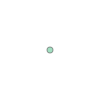

In [72]:
geometry = [sg.Point(x, y) for x, y in zip(latitudes, longitudes)]
print(geometry[0].bounds)
geometry[0]

In [73]:
gdf = gpd.GeoDataFrame(df_clean, geometry=geometry, crs={'init': 'epsg:4326'})
gdf.iloc[1]

id                                                          I-LU-15621
category             Unità immobiliare per uso di abitazione e assi...
subcategory                                 Appartamento in condominio
province                                                         Lucca
municipality                                                Altopascio
status                                             Confisca definitiva
is_a_company                                                     False
is_managed                                                       False
link                 http://www.regione.toscana.it/-/altopascio-loc...
judicial_district                                      Reggio Calabria
geometry                   POINT (10.71437458517167 43.81120950309401)
Name: 1, dtype: object

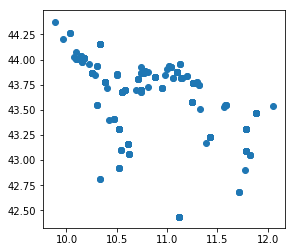

In [74]:
gdf.plot()

## Let's create a map with Folium

In [75]:
Florence = (43.769562, 11.255814)  # lat, lon

In [76]:
# Check the list of tile providers here: https://python-visualization.github.io/folium/modules.html
m = folium.Map(location=Florence, tiles='OpenStreetMap', zoom_start=8)

# for i, row in gdf.iloc[:10].iterrows():
for i, row in gdf.iterrows():
    lon, lat = row.geometry.bounds[:2]
    
    if row.link == 'NaN':
        elem = '<span><del>Link not Available</del></span>'
    else:
        elem = '<a href="{}" target="_blank">Link</a>'.format(row.link)
        
    
    html = """
    <h3>{title}</h3>
    <p><b>Category</b></p>
    <p>{category}</p>
    <p><b>Subcategory</b></p>
    <p>{subcategory}</p>
    <br>
    {link_tag}
    """.format(title=row.id, category=row.category, subcategory=row.subcategory, link_tag=elem)
    
    folium.Marker(
        location=(lat, lon),
        popup=html,
        icon=folium.Icon(color='green', icon='info-sign'),
    ).add_to(m)

m

Save the map, so we can deploy it on a static web hosting provider like [Amazon AWS S3](https://aws.amazon.com/s3/), [Surge.sh](https://surge.sh/), [Netlify](https://www.netlify.com/), [GitHub Pages](https://pages.github.com/), [Aerobatic](https://www.aerobatic.com/), etc...

In [77]:
m.save('index.html')

## Export

In [81]:
import fiona
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'OpenFileGDB': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GPKG': 'rw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'SEGY': 'r',
 'SUA': 'r'}

In [91]:
# TODO: there are some issues with the export. The files are generated, but a ValueError is raised.
# gdf.to_file(driver='ESRI Shapefile', filename='data.shp')